# КУРСАЧ

In [1]:

import numpy as np
import pandas as pd
import pickle  
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


from lightgbm import LGBMRegressor



from sklearn.metrics import mean_squared_error as mse, r2_score as r2


from IPython.display import Image

matplotlib.rcParams.update({'font.size': 14})

In [2]:
raw_dataset_path = r'datasets/realestatepriceprediction/train.csv'
prepared_ds_path = r'datasets/realestatepriceprediction/train_prep.csv'

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Data fields<br>
* **Id** - идентификационный номер квартиры<br>
* **DistrictId** - идентификационный номер района<br>
* **Rooms** - количество комнат<br>
* **Square** - площадь<br>
* **LifeSquare** - жилая площадь<br>
* **KitchenSquare** - площадь кухни<br>
* **Floor** - этаж<br>
* **HouseFloor** - количество этажей в доме<br>
* **HouseYear** - год постройки дома<br>
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности<br>
* **Social_1, Social_2, Social_3** - социальные показатели местности<br>
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья<br>
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров<br>
* **Price** - цена квартиры

In [4]:
df_train = pd.read_csv(raw_dataset_path)

In [5]:
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [6]:
df_train = reduce_mem_usage(df_train)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [7]:
df_train.set_index('Id', inplace=True)

In [8]:
df_train.head(15)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.937500
15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.437500
4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250
5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.234375
10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531250
12915,59,3.0,80.384476,46.683720,12.0,5,17.0,2011,0.309479,B,B,35,7715,4,990.0,0,6,B,215898.453125
14549,154,2.0,62.254112,37.160378,7.0,3,5.0,1960,0.460556,B,B,20,4386,14,NaN,1,5,B,296021.218750
11993,74,2.0,80.312927,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156250
5172,1,2.0,64.511436,NaN,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.796875


In [9]:
target = df_train['Price']

In [10]:
target.head()

Id
14038    184966.937500
15053    300009.437500
4765     220925.906250
5809     175616.234375
10783    150226.531250
Name: Price, dtype: float32

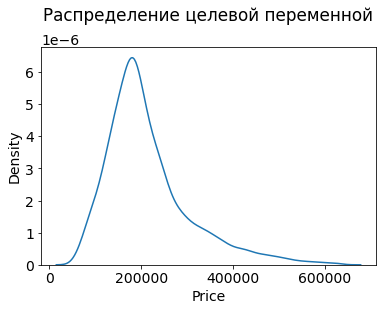

In [11]:
sns.kdeplot(target)
plt.title('Распределение целевой переменной\n')
plt.show()

In [12]:
df_train = df_train.drop(columns='Price')

In [13]:
df_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B
15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B
4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B
5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B


In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   DistrictId     10000 non-null  int16   
 1   Rooms          10000 non-null  float32 
 2   Square         10000 non-null  float32 
 3   LifeSquare     7887 non-null   float32 
 4   KitchenSquare  10000 non-null  float32 
 5   Floor          10000 non-null  int8    
 6   HouseFloor     10000 non-null  float32 
 7   HouseYear      10000 non-null  int32   
 8   Ecology_1      10000 non-null  float32 
 9   Ecology_2      10000 non-null  category
 10  Ecology_3      10000 non-null  category
 11  Social_1       10000 non-null  int8    
 12  Social_2       10000 non-null  int16   
 13  Social_3       10000 non-null  int16   
 14  Healthcare_1   5202 non-null   float32 
 15  Helthcare_2    10000 non-null  int8    
 16  Shops_1        10000 non-null  int8    
 17  Shops_2        10000 non-nul

In [15]:
df_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300
std,43.587592,0.839523,21.058718,86.241112,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000
50%,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000
75%,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000
max,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000


## Выбросы

Вообще, логика образования выбросов лежит в каких-то аксиомах, которые образуются в зависимости от того, как мы воспринимаем данные. Поэтому я предположу следующее:
* Объекты в датасете являются жилыми, то есть полагается, что $LifeSquare \neq 0$.
* Так же будем полагать, что есть ситуации, когда $KitchenSquare = 0$, то есть речь может гипотетически идти про квартиры-студии, где четко не определена площадь кухни
* Единицы измерения будет считать следующие: $Square, LifeSquare, KitchenSquare - m^{2}$, а цены (судя по значениям) - тысячи долларов<br>
##### Таким образом, будем считать выбросами:
<br>
* $HouseYear > 2021$
* $Floor = 0, HouseFloor = 0$
* $Floor > HouseFloor$
* $Square < 20$
* $KitchenSquare > Square$
* $LifeSquare > Square, LifeSquare = NaN$, опять же, исходя из того, что все дома в датасете - жилые.
* $Rooms = 0$
* $(Rooms > 5,$ $\frac{Square}{Rooms} < 30)$ - имеется ввиду логическое $AND$ этих ситуаций, причем число 30 получилось как медианное от площади, которая приходится на одну комнату, то есть слишком большое число комнат при не особо большой площади.
<p><i>Вот с последнем лично у меня вопросы появляются, ибо пологаю, что можно представить какой-то жилой объект с 6-тью комнатами по ~20 квадратов каждая. Ровно, как и сложно представить жилое нечто площадью 5 квадратов (это кухня в хрущевке 60-х годов, где развернуться сложно), но тем не менее в бейслайне вообще порог в 3 квадрата был. Поэтому в силу моего очень скудного знания рынка недвижимости, положу такие критерии выбросов</i></p>

#### штош...

### Выбросы HouseYear

In [16]:
df_train.loc[df_train['HouseYear'] > 2021, 'HouseYear'] = 2021

In [17]:
df_train.describe()['HouseYear']

count    10000.000000
mean      1984.872600
std         18.416734
min       1910.000000
25%       1974.000000
50%       1977.000000
75%       2001.000000
max       2021.000000
Name: HouseYear, dtype: float64

### Выбросы Floor

In [18]:
df_train.describe()[['Floor', 'HouseFloor']]

,Floor,HouseFloor
count,10000.000000,10000.000000
mean,8.526700,12.609400
std,5.241148,6.776192
min,1.000000,0.000000
25%,4.000000,9.000000
50%,7.000000,13.000000
75%,12.000000,17.000000
max,42.000000,117.000000


У нас нет ситуаций $Floor = 0$, но есть случаи $HouseFloor = 0$.<br>
Построим еще график, чтобы увидеть как распределены объекты в координатах этажей, причем, добавим на этот график линию $y=x$, выше которой будут рапологаться выбросные объекты.

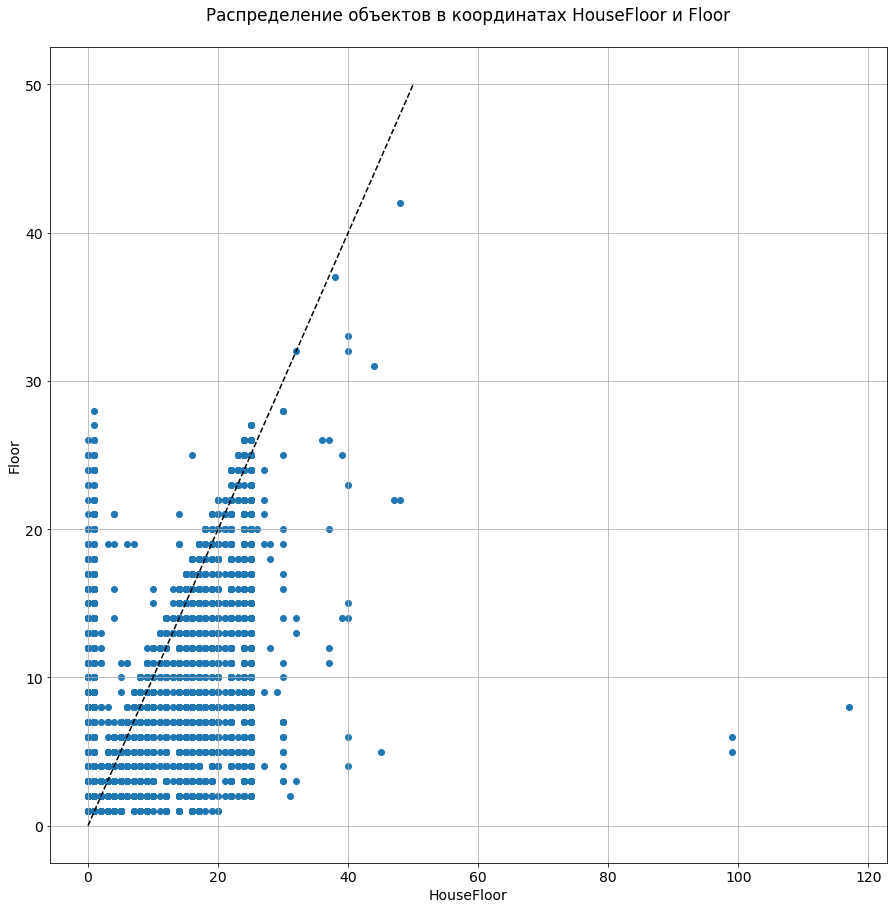

In [19]:
plt.figure(figsize=(15,15))
plt.plot([0, 50], [0, 50], linestyle='--', color='black')
plt.grid()
plt.scatter(df_train['HouseFloor'], df_train['Floor'])
plt.title('Распределение объектов в координатах HouseFloor и Floor\n')
plt.xlabel('HouseFloor')
plt.ylabel('Floor')
plt.show()

Видно, что есть много объектов, у которых этаж чуть больше, чем этажей всего в доме, причем, они почти равномерно распределены вдоль границы выбросов (пунктирная линия которая). Плюс есть много объектов, с разными значениями этажей при $HouseFloor = 1$.<br>
Таким образом, я предположу, что скорее всего причина этих выбросов - кто-то перепутал Floor с HouseFloor (я сам это неоднократно делал при выполнении задания), поэтому я просто поменяю их местами (и таким образом у меня получится много квартир на первом этаже, что находится в соответствии с фактом малой популярности квартир на первом этаже, ну, насколько я знаю/слышал об этом). А $HouseFloor = 0$ просто приравняю к значению этажа.

#### обработаем выбросы с этажами

In [20]:
df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor'] = df_train.loc[df_train['HouseFloor'] == 0, 'Floor']

Здесь я введу новый признак, который буду использовать сейчас для фильтрации выборки, ну, и потом для обучения модели

In [21]:
df_train['FloorPos'] = df_train['Floor'] / df_train['HouseFloor']

Теперь поменяем местами HouseFloor и Floor и построим график рапределеня объектов в этажных координатах.

In [22]:
must_be_housefloor = df_train.loc[df_train['FloorPos'] > 1, 'Floor']
df_train.loc[df_train['FloorPos'] > 1, 'Floor'] = df_train.loc[df_train['FloorPos'] > 1, 'HouseFloor']
df_train.loc[df_train['FloorPos'] > 1, 'HouseFloor'] = must_be_housefloor

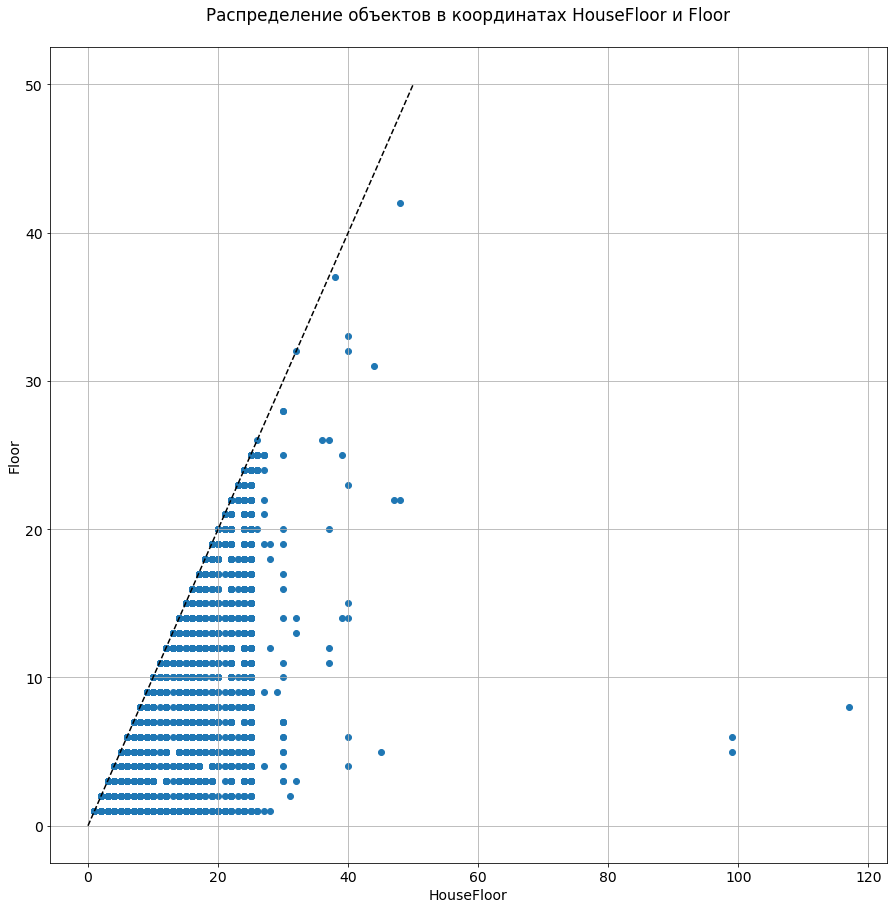

In [23]:
plt.figure(figsize=(15,15))
plt.plot([0, 50], [0, 50], linestyle='--', color='black')
plt.grid()
plt.scatter(df_train['HouseFloor'], df_train['Floor'])
plt.title('Распределение объектов в координатах HouseFloor и Floor\n')
plt.xlabel('HouseFloor')
plt.ylabel('Floor')
plt.show()

Видим, что все стало красиво и все элементы лежат под линией.<br>
И теперь пересчитаем фичу FloorPos

In [24]:
df_train['FloorPos'] = df_train['Floor'] / df_train['HouseFloor']

### Выбросы Squares и Rooms

Общие положения по поводу этих выбросов описаны выше, а последовательность действий будет следующая:
* Делаем фичи $SquarePerRoom = \frac{Square}{Square}, LifeSqRatio = \frac{LifeSquare}{Square}, KitchenSqRatio = \frac{KitchenSquare}{Square}$, которые будем использовать сейчас для фильтрации выборки, и в дальнейшем для обучения модели, а так же медианные значения будем использовать для трансформа тестового датасета
* В случаях $Square < 20, Square$ делаем равными 20-ти. Значение в 600 квадратов считаем... ну, не считаем выбросом. А еще считаем, что площадь будет независимой переменной, вокруг которой будем менять другие признаки
* В случаях $KitchenSquare > Square$ считаем медианное значение признака $KitchenSqRatio$ и умножаем выбросные $KitchenSquare$ на эту медиану, которую в свою очередь сохраняем для трансформа тестового датасета
* Для выбросов в $Rooms$ общий принцип: считаем медиану по $SquarePerRoom$, и потом меняем все выбросные комнаты вот так $Rooms = \left[ \frac{Square}{median(SquarePerRoom)} \right]+1$ квадратные скобочки - деление нацело
* Для $LifeSquare > Square$ я определил границу в $LifeSqRatio = 1.2$ и все те, $LifeSquare$, для которых $LifeSqRatio \in \left[ 1, 1.2 \right]$, будем менять местами по той же логике, что и с этажами, т.к. жилая площадь более употребительное свойство, нежели чем кухонная площадь, и в выбросных жилых площадях очень много значений, которые совсем чуть-чуть превосходят значение площади. Ну, а  $LifeSquare$, для которых $LifeSqRatio \in \left[ 1.2, \infty \right)$, будем умножать $Square$ на медианное значение $LifeSqRatio$, которое потом будем использовать для трансформа тестового датасета

In [25]:
square_feats = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare']

In [26]:
df_train[square_feats].describe()

,Rooms,Square,LifeSquare,KitchenSquare
count,10000.000000,10000.000000,7887.000000,10000.000000
mean,1.890500,56.315712,37.199596,6.273300
std,0.839523,21.058718,86.241112,28.561113
min,0.000000,1.136859,0.370619,0.000000
25%,1.000000,41.774879,22.769833,1.000000
50%,2.000000,52.513309,32.781261,6.000000
75%,2.000000,65.900627,45.128803,9.000000
max,19.000000,641.065186,7480.592285,2014.000000


#### Выбросы в Square

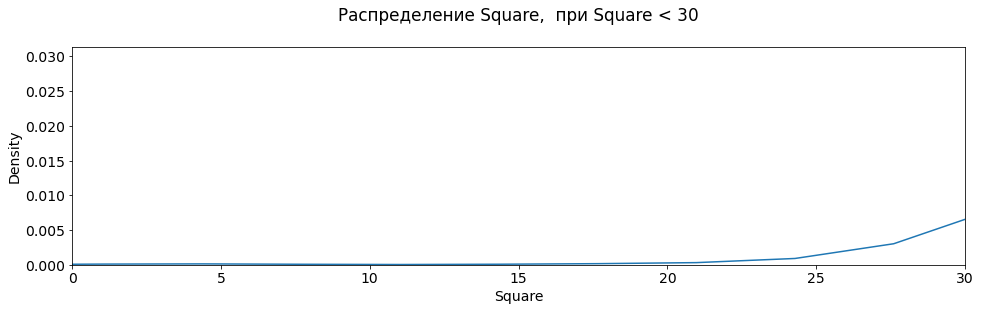

In [27]:
plt.figure(figsize=(16,4))

sns.kdeplot(df_train['Square'])
plt.xlim(0, 30)
plt.title('Распределение Square,  при Square < 30\n')
plt.show()

Вот видим, что очень мало значений ниже 20 квадратов лежит

In [28]:
df_train.loc[df_train['Square'] < 20, 'Square'] = 20

##### Введем новые фичи

In [29]:
df_train['SquarePerRoom'] = df_train['Square'] / df_train['Rooms']
df_train['LifeSqRatio'] = df_train['LifeSquare'] / df_train['Square']
df_train['KitchenSqRatio'] = df_train['KitchenSquare'] / df_train['Square']

Построим здоровенный график

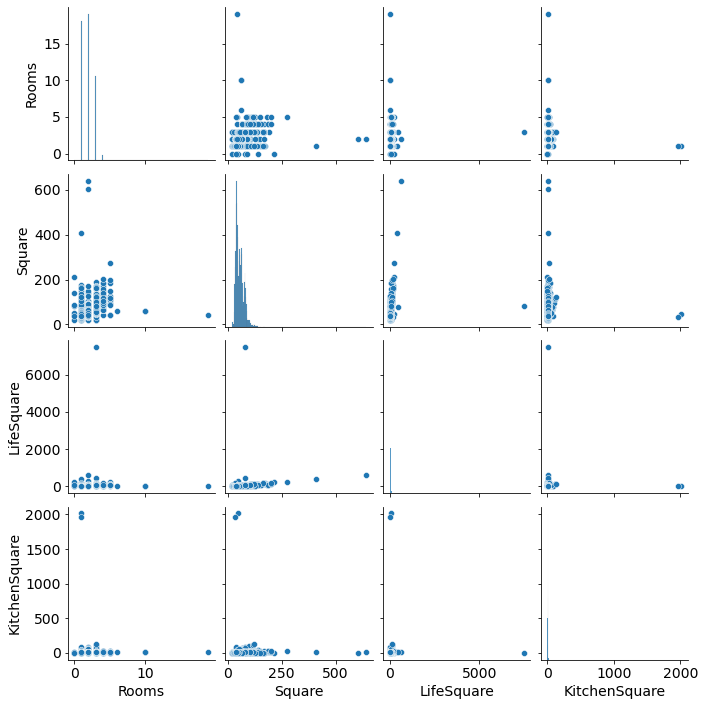

In [30]:
sns.pairplot(df_train[square_feats])

#### Выбросы в KitchenSquare

In [31]:
df_train.loc[df_train['KitchenSquare'] > df_train['Square'], square_feats]

,Rooms,Square,LifeSquare,KitchenSquare
Id,,,,
14656,1.0,47.100719,46.447960,2014.0
13703,1.0,38.071693,19.723547,73.0
6569,1.0,38.220257,18.716856,84.0
14679,1.0,32.276665,19.278395,1970.0


In [32]:
kitchen_med = df_train.loc[df_train['KitchenSqRatio'] < 1, 'KitchenSqRatio'].median()

Медиану эту сохраняем и будем использовать в дальнейшем

In [33]:
df_train.loc[df_train['KitchenSqRatio'] > 1, 'KitchenSquare'] =\
                                                     df_train.loc[df_train['KitchenSqRatio'] > 1, 'Square'] * kitchen_med

Пересчитаем долю кухонной площади

In [34]:
df_train['KitchenSqRatio'] = df_train['KitchenSquare'] / df_train['Square']

#### Выбросы в Rooms

In [35]:
df_train.loc[df_train['Rooms'] == 0, square_feats]

,Rooms,Square,LifeSquare,KitchenSquare
Id,,,,
12638,0.0,138.427689,136.215500,0.0
7917,0.0,212.932358,211.231125,0.0
7317,0.0,41.790882,NaN,0.0
770,0.0,49.483501,NaN,0.0
456,0.0,81.491447,NaN,0.0
3224,0.0,20.000000,0.873147,0.0
3159,0.0,38.697117,19.345131,9.0
9443,0.0,87.762619,85.125473,0.0


Посчитаем и сохраним медианное значение площади одной комнаты

In [36]:
room_sq_med = df_train.loc[df_train['Rooms'] != 0, 'SquarePerRoom'].median()
room_sq_med

30.82149887084961

In [37]:
df_train.loc[df_train['Rooms'] == 0, 'Rooms'] = (df_train.loc[df_train['Rooms'] == 0, 'Square'] // room_sq_med) + 1

Убрали нулевые комнаты, поэтому можно пересчитать $SquarePerRoom$

In [38]:
df_train['SquarePerRoom'] = df_train['Square'] / df_train['Rooms']

In [39]:
df_train.loc[(df_train['Rooms'] > 5) & (df_train['SquarePerRoom'] < 30), square_feats]

,Rooms,Square,LifeSquare,KitchenSquare
Id,,,,
5927,10.0,59.056976,36.223072,10.0
8491,19.0,42.006046,21.779287,7.0
14003,6.0,59.414333,38.702244,6.0
14865,10.0,60.871265,38.420681,10.0


In [40]:
df_train.loc[(df_train['Rooms'] > 5) & (df_train['SquarePerRoom'] < 30), 'Rooms'] =\
            (df_train.loc[(df_train['Rooms'] > 5) & (df_train['SquarePerRoom'] < 30), 'Square'] // room_sq_med) + 1

Опять пересчитаем фичу $SquarePerRoom$

In [41]:
df_train['SquarePerRoom'] = df_train['Square'] / df_train['Rooms']

In [42]:
df_train.loc[df_train['SquarePerRoom'] < 5, square_feats]

,Rooms,Square,LifeSquare,KitchenSquare
Id,,,,


Ситуаций, когда одна комната занимает меньше 5 квадратов, тоже нет

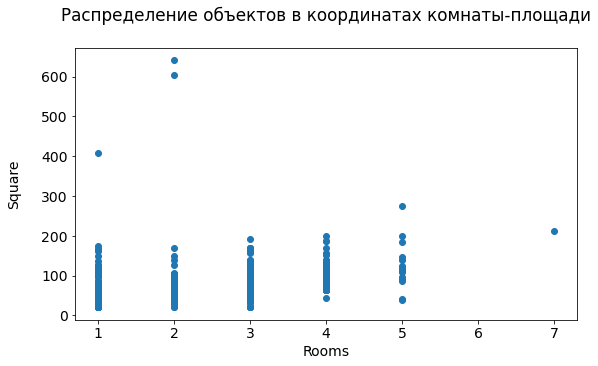

In [43]:
plt.figure(figsize=(9, 5))
plt.scatter(df_train['Rooms'], df_train['Square'])
plt.title('Распределение объектов в координатах комнаты-площади\n')
plt.xlabel('Rooms')
plt.ylabel('Square\n')
plt.show()

### LifeSquare

Text(0, 0.5, 'LifeSquare')

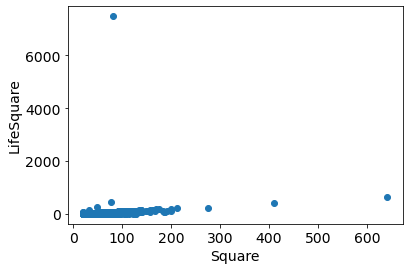

In [44]:
plt.scatter(df_train['Square'], df_train['LifeSquare']);
plt.xlabel('Square')
plt.ylabel('LifeSquare')

Сохраним медианное значение доли от общей площади, которую занимает жилая площадь

In [45]:
life_sq_med = df_train.loc[df_train['LifeSqRatio'] < 1, 'LifeSqRatio'].median()
life_sq_med

0.6105387210845947

На графике виден выброс прям сильный, где $LifeSquare$ аномально большая. Устраним его.

In [46]:
df_train.loc[df_train['LifeSquare'] > 700, 'LifeSquare'] = df_train.loc[df_train['LifeSquare'] > 700, 'Square'] * life_sq_med

Пересчитаем долю жилой площади

In [47]:
df_train['LifeSqRatio'] = df_train['LifeSquare'] / df_train['Square']

In [48]:
df_train.loc[df_train['LifeSqRatio'] > 1, square_feats]

,Rooms,Square,LifeSquare,KitchenSquare
Id,,,,
8054,1.0,42.530045,43.967758,1.0
10521,3.0,104.211395,106.340401,0.0
2301,2.0,61.400055,65.224602,0.0
8753,3.0,85.952309,89.803749,1.0
9870,1.0,51.831474,53.491302,1.0
...,...,...,...,...
41,2.0,59.015896,59.439083,12.0
12918,2.0,51.440464,53.134243,51.0
2737,3.0,123.430069,125.806984,123.0


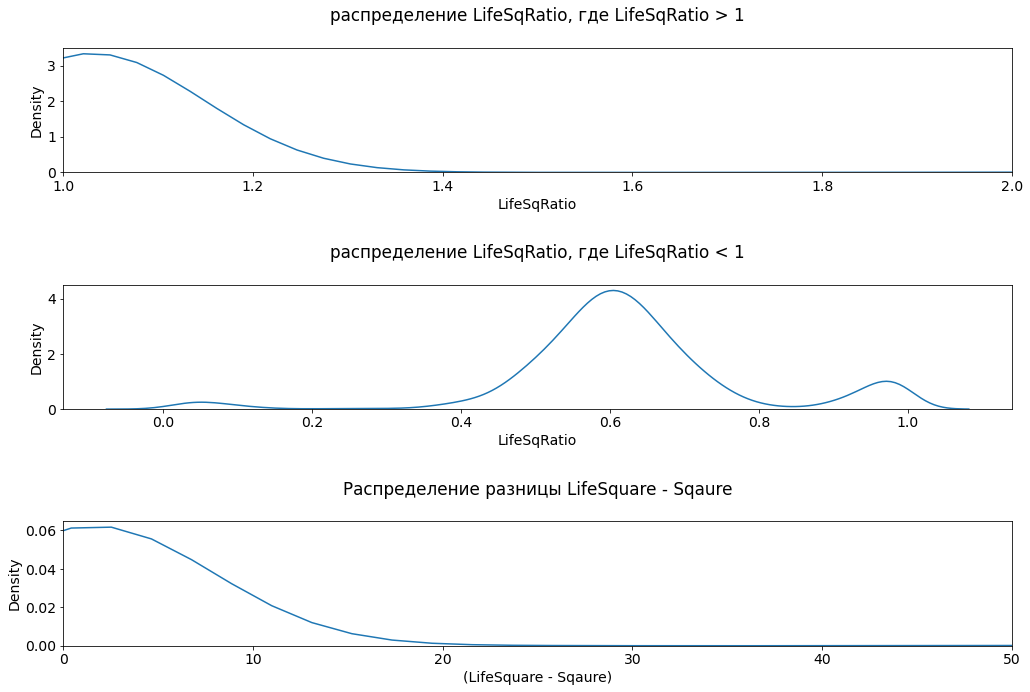

In [49]:
plt.figure(figsize=(17, 11))


plt.subplot(311)
sns.kdeplot(df_train.loc[df_train['LifeSqRatio'] > 1, 'LifeSqRatio'])
plt.xlim(1, 2)
plt.title('распределение LifeSqRatio, где LifeSqRatio > 1\n')
plt.subplots_adjust(wspace=0.3, hspace=0.9)

plt.subplot(312)
sns.kdeplot(df_train.loc[df_train['LifeSqRatio'] < 1, 'LifeSqRatio'])
plt.title('распределение LifeSqRatio, где LifeSqRatio < 1\n')

plt.subplot(313)
sns.kdeplot(df_train.loc[df_train['LifeSqRatio'] > 1, 'LifeSquare'] - df_train.loc[df_train['LifeSqRatio'] > 1, 'Square'])
plt.xlim(0, 50)
plt.title('Распределение разницы LifeSquare - Sqaure\n')
plt.xlabel('(LifeSquare - Sqaure)')
plt.show()

Вот видим на первом графике 1.2, которую возьмем за границу. И все, что меньше - меняем местами, а что больше - умножаем на медиану.

In [50]:
life_sq_thld = 1.2

In [51]:
df_train.loc[df_train['LifeSqRatio'] > life_sq_thld, 'LifeSquare'] =\
                            df_train.loc[df_train['LifeSqRatio'] > life_sq_thld, 'Square'] * life_sq_med

In [52]:
must_be_square = df_train.loc[(df_train['LifeSqRatio'] < life_sq_thld) & (df_train['LifeSqRatio'] > 1), 'LifeSquare']

df_train.loc[(df_train['LifeSqRatio'] < life_sq_thld) & (df_train['LifeSqRatio'] > 1), 'LifeSquare'] =\
            df_train.loc[(df_train['LifeSqRatio'] < life_sq_thld) & (df_train['LifeSqRatio'] > 1), 'Square']

df_train.loc[(df_train['LifeSqRatio'] < life_sq_thld) & (df_train['LifeSqRatio'] > 1), 'Square'] = must_be_square

In [53]:
df_train.loc[(df_train['LifeSqRatio'] < life_sq_thld) & (df_train['LifeSqRatio'] > 1), square_feats]

,Rooms,Square,LifeSquare,KitchenSquare
Id,,,,
8054,1.0,43.967758,42.530045,1.0
10521,3.0,106.340401,104.211395,0.0
2301,2.0,65.224602,61.400055,0.0
8753,3.0,89.803749,85.952309,1.0
9870,1.0,53.491302,51.831474,1.0
...,...,...,...,...
41,2.0,59.439083,59.015896,12.0
12918,2.0,53.134243,51.440464,51.0
2737,3.0,125.806984,123.430069,123.0


Видим, что все хорошо, поэтому можем пересчитать фичу $LifeSqRatio$ и ее же медиану

In [54]:
df_train['LifeSqRatio'] = df_train['LifeSquare'] / df_train['Square']
life_sq_med = df_train['LifeSqRatio'].median()

Теперь заполним NaN в $LifeSquare$

In [55]:
df_train.loc[df_train['LifeSquare'].isna(), 'LifeSquare'] = df_train.loc[df_train['LifeSquare'].isna(), 'Square'] * life_sq_med

И опять пересчитаем фичу с ее медианой

In [56]:
df_train['LifeSqRatio'] = df_train['LifeSquare'] / df_train['Square']
life_sq_med = df_train['LifeSqRatio'].median()

In [57]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   DistrictId      10000 non-null  int16   
 1   Rooms           10000 non-null  float32 
 2   Square          10000 non-null  float32 
 3   LifeSquare      10000 non-null  float32 
 4   KitchenSquare   10000 non-null  float32 
 5   Floor           10000 non-null  float32 
 6   HouseFloor      10000 non-null  float32 
 7   HouseYear       10000 non-null  int32   
 8   Ecology_1       10000 non-null  float32 
 9   Ecology_2       10000 non-null  category
 10  Ecology_3       10000 non-null  category
 11  Social_1        10000 non-null  int8    
 12  Social_2        10000 non-null  int16   
 13  Social_3        10000 non-null  int16   
 14  Healthcare_1    5202 non-null   float32 
 15  Helthcare_2     10000 non-null  int8    
 16  Shops_1         10000 non-null  int8    
 17  Shops_2  

Таким образом мы обработали пропуски и выбросы.

### Генерация фич
Значит то, что получилось в итоге (как говорила Вероника, что надо оставить только готовое уже решение):
* 4 фичи по площадям и "высоте" квартиры уже сделаны выше
* как и в бейслайне, дропаем Healthcare_1, ибо там почти половина пропусков
* затем сделаем фичу DistCounts таким же образом, как и в, опять же, бейслайне (отсылаясь к словам Вероники: "эту задачу уже много раз решали, значит, есть такая особенность"). Причем, сначала я ее не делал и скор был 7.2 где-то, но ввиду того, что уже дедлайн наступает на разные части тела, я сделаю так же
* сделаем фичу медианного возраста домов в районе (можно назвать возрастом района), причем, интерпретируем ее в категориальный признак very old/old/new
* ну, и сделаем среднюю цену по району (она тоже была в бейслайне, но она же сама так и просится!! захочу вот купить квартиру на Пресне или Сретенке в Москве - и к бабке не ходи - готовь сразу вагон и малую тележку денег, и на большее, чем туалет 2х2, можно не рассчитывать, короче очень интуитивная фича)
* а потом делаем дамми-переменные

Дропаем здравоохранение_1

In [58]:
df_train.drop(columns='Healthcare_1', inplace=True)

#### районные фичи 
##### DistCounts

In [59]:
dist = df_train['DistrictId'].value_counts()
#dist = dist[dist > 50]
dist_dict = dict(dist)

In [60]:
df_train['DistCounts'] = df_train['DistrictId'].map(dist_dict)

In [61]:
df_train.loc[df_train['DistCounts'] < 50, 'DistCounts'] = 5

##### DistAge

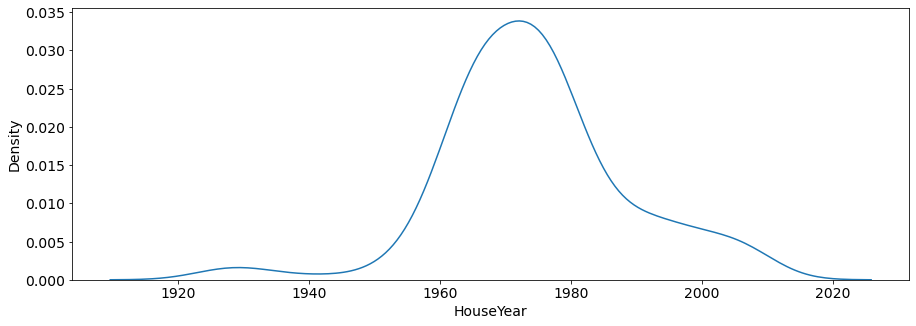

In [62]:
plt.figure(figsize=(15, 5))
sns.kdeplot(df_train.groupby('DistrictId').HouseYear.median());

На основании графика положу вот так:
* $HouseYear \le 1945$ - 'very old'
* $1946 < HouseYear \le 1990$ - 'old'
* $HouseYear > 1990$ - 'new'

In [63]:
dist_med_year= dict(df_train.groupby('DistrictId').HouseYear.median())


In [64]:
dist_age = {}
for k, j in dist_med_year.items():
    if (j <= 1945):
        dist_age[k] = 'very old'
    elif (j > 1945) & (j <= 1990):
        dist_age[k] = 'old'
    elif (j > 1990):
        dist_age[k] = 'new'
        


In [65]:
df_train['DistAge'] = df_train['DistrictId'].map(dist_age)

##### DistMedPrice

In [66]:
for_price_feats = pd.merge(df_train, target, left_index=True, right_index=True)[['DistrictId', 'Price']]

In [67]:
price_med_dict = dict(for_price_feats.groupby('DistrictId').Price.median())

In [68]:
df_train['DistMedPrice'] = df_train.DistrictId.map(price_med_dict)

In [69]:
df_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,FloorPos,SquarePerRoom,LifeSqRatio,KitchenSqRatio,DistCounts,DistMedPrice
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.889300,56.413673,36.296188,5.861076,7.943200,13.435700,1984.872600,0.118858,24.687000,5352.157400,8.039200,1.319500,4.231300,0.606983,32.517223,0.637369,0.112233,237.316000,201916.213420
std,43.587592,0.813468,21.029543,18.375534,5.070415,5.228094,6.094035,18.416734,0.119026,17.532614,4006.799803,23.831875,1.493601,4.806341,0.284851,11.362876,0.157833,0.087901,273.041493,54733.928467
min,0.000000,1.000000,20.000000,0.370619,0.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.035714,6.666667,0.006001,0.000000,5.000000,113789.562500
25%,20.000000,1.000000,41.863287,24.219597,1.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,0.000000,1.000000,0.352941,25.590845,0.574760,0.022591,55.000000,168980.375000
50%,36.000000,2.000000,52.592594,33.240864,6.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,1.000000,3.000000,0.642857,30.808279,0.617137,0.120504,104.000000,189439.609375
75%,75.000000,2.000000,65.985905,44.764771,9.000000,11.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,2.000000,6.000000,0.875000,38.990761,0.667346,0.164944,511.000000,223672.312500
max,209.000000,7.000000,641.065186,638.163208,123.000000,42.000000,117.000000,2021.000000,0.521867,74.000000,19083.000000,141.000000,6.000000,23.000000,1.000000,409.425171,0.999949,0.997338,851.000000,526438.437500


In [70]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   DistrictId      10000 non-null  int16   
 1   Rooms           10000 non-null  float32 
 2   Square          10000 non-null  float32 
 3   LifeSquare      10000 non-null  float32 
 4   KitchenSquare   10000 non-null  float32 
 5   Floor           10000 non-null  float32 
 6   HouseFloor      10000 non-null  float32 
 7   HouseYear       10000 non-null  int32   
 8   Ecology_1       10000 non-null  float32 
 9   Ecology_2       10000 non-null  category
 10  Ecology_3       10000 non-null  category
 11  Social_1        10000 non-null  int8    
 12  Social_2        10000 non-null  int16   
 13  Social_3        10000 non-null  int16   
 14  Helthcare_2     10000 non-null  int8    
 15  Shops_1         10000 non-null  int8    
 16  Shops_2         10000 non-null  category
 17  FloorPos 

Закастим DistAge к категориальному признаку

In [71]:
df_train['DistAge'] = df_train['DistAge'].astype('category')

In [72]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   DistrictId      10000 non-null  int16   
 1   Rooms           10000 non-null  float32 
 2   Square          10000 non-null  float32 
 3   LifeSquare      10000 non-null  float32 
 4   KitchenSquare   10000 non-null  float32 
 5   Floor           10000 non-null  float32 
 6   HouseFloor      10000 non-null  float32 
 7   HouseYear       10000 non-null  int32   
 8   Ecology_1       10000 non-null  float32 
 9   Ecology_2       10000 non-null  category
 10  Ecology_3       10000 non-null  category
 11  Social_1        10000 non-null  int8    
 12  Social_2        10000 non-null  int16   
 13  Social_3        10000 non-null  int16   
 14  Helthcare_2     10000 non-null  int8    
 15  Shops_1         10000 non-null  int8    
 16  Shops_2         10000 non-null  category
 17  FloorPos 

Делаем дамми-переменные

In [73]:
df_train = pd.get_dummies(df_train)

In [74]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DistrictId        10000 non-null  int16  
 1   Rooms             10000 non-null  float32
 2   Square            10000 non-null  float32
 3   LifeSquare        10000 non-null  float32
 4   KitchenSquare     10000 non-null  float32
 5   Floor             10000 non-null  float32
 6   HouseFloor        10000 non-null  float32
 7   HouseYear         10000 non-null  int32  
 8   Ecology_1         10000 non-null  float32
 9   Social_1          10000 non-null  int8   
 10  Social_2          10000 non-null  int16  
 11  Social_3          10000 non-null  int16  
 12  Helthcare_2       10000 non-null  int8   
 13  Shops_1           10000 non-null  int8   
 14  FloorPos          10000 non-null  float32
 15  SquarePerRoom     10000 non-null  float32
 16  LifeSqRatio       10000 non-null  flo

И кастим к категориальным фичами $DistrictId, HouseYear$

In [75]:
df_train['DistrictId'] = df_train['DistrictId'].astype('category')
df_train['HouseYear'] = df_train['HouseYear'].astype('category')

In [76]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   DistrictId        10000 non-null  category
 1   Rooms             10000 non-null  float32 
 2   Square            10000 non-null  float32 
 3   LifeSquare        10000 non-null  float32 
 4   KitchenSquare     10000 non-null  float32 
 5   Floor             10000 non-null  float32 
 6   HouseFloor        10000 non-null  float32 
 7   HouseYear         10000 non-null  category
 8   Ecology_1         10000 non-null  float32 
 9   Social_1          10000 non-null  int8    
 10  Social_2          10000 non-null  int16   
 11  Social_3          10000 non-null  int16   
 12  Helthcare_2       10000 non-null  int8    
 13  Shops_1           10000 non-null  int8    
 14  FloorPos          10000 non-null  float32 
 15  SquarePerRoom     10000 non-null  float32 
 16  LifeSqRatio       1

Трейновый датасет готов, можно его сохранить и переходить к изменению теста.

In [77]:
df_train.to_csv(prepared_ds_path)

## Test dataset transform
### Выбросы
Для преобразования тестового датасета будут использоваться та же логика, что и при трансформе трейнового, а так же медианные значения из трейнового датасета.

In [78]:
raw_test = r'datasets/realestatepriceprediction/test.csv'
prep_test = r'datasets/realestatepriceprediction/test_prep.csv'

In [79]:
df_test = pd.read_csv(raw_test)

In [80]:
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


In [81]:
df_test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449501,36.158760,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657227,1.31940,4.242800
std,4832.674037,44.179466,0.838587,19.092793,17.825277,9.950147,5.483228,6.789167,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744995,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906230,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921339,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285130,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453690,303.071106,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


Года, этажи, площади и комнаты.

##### HouseYear

In [82]:
df_test.loc[df_test['HouseYear'] > 2021]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2


По годам выбросов нет.

##### HouseFloor, Floor

In [83]:
df_test.loc[df_test['HouseFloor'] == 0, 'HouseFloor'] = df_test.loc[df_test['HouseFloor'] == 0, 'Floor']

In [84]:
df_test['FloorPos'] = df_test['Floor'] / df_test['HouseFloor']

In [85]:
df_test.loc[df_test['FloorPos'] > 1, ['Floor', 'HouseFloor']]

,Floor,HouseFloor
1,6,1.0
10,10,9.0
14,5,1.0
27,4,3.0
36,6,5.0
...,...,...
4968,4,1.0
4972,2,1.0
4989,10,9.0
4993,6,5.0


Меняем этажи местами

In [86]:
must_be_housefloor = df_test.loc[df_test['FloorPos'] > 1, 'Floor']
df_test.loc[df_test['FloorPos'] > 1, 'Floor'] = df_test.loc[df_test['FloorPos'] > 1, 'HouseFloor']
df_test.loc[df_test['FloorPos'] > 1, 'HouseFloor'] = must_be_housefloor

Пересчитаем этажную фичу

In [87]:
df_test['FloorPos'] = df_test['Floor'] / df_test['HouseFloor']

In [88]:
df_test.loc[df_test['FloorPos'] > 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,FloorPos


С этажами все

##### Squares, Rooms

In [89]:
df_test.loc[df_test['Square'] < 20]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,FloorPos
2,5480,190,1.0,13.597818,15.948246,12.0,2.0,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B,0.400000
66,9011,53,1.0,1.378543,1.353573,1.0,1.0,1.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B,1.000000
557,3458,101,1.0,19.043894,13.941145,3.0,4.0,5.0,1970,0.225825,A,B,41,6558,7,1548.0,3,2,B,0.800000
608,16401,30,1.0,2.645046,4.338756,1.0,1.0,2.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,0.500000
837,2138,27,1.0,5.647459,1.501582,1.0,1.0,1.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,1.000000
1165,10120,6,1.0,5.100671,3.861780,1.0,1.0,3.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,0.333333
1195,3969,101,1.0,18.149267,9.698766,3.0,4.0,5.0,1967,0.225825,A,B,41,6558,7,1548.0,3,2,B,0.800000
1441,9884,29,1.0,17.273699,16.452171,2.0,3.0,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B,0.600000
2744,7533,66,1.0,16.319016,11.118981,1.0,4.0,5.0,1965,0.111627,B,B,50,12238,8,1970.0,2,3,B,0.800000
2895,6894,84,1.0,19.166821,14.865172,0.0,5.0,6.0,1965,0.149666,B,B,22,4789,2,4087.0,4,1,B,0.833333


Все малые площади делаем равными 20-ти

In [90]:
df_test.loc[df_test['Square'] < 20, 'Square'] = 20

Введем фичи для площадей

In [91]:
df_test['SquarePerRoom'] = df_test['Square'] / df_test['Rooms']
df_test['KitchenSqRatio'] = df_test['KitchenSquare'] / df_test['Square']
df_test['LifeSqRatio'] = df_test['LifeSquare'] / df_test['Square']

###### KitchenSquare

In [92]:
df_test.loc[df_test['KitchenSqRatio'] > 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,FloorPos,SquarePerRoom,KitchenSqRatio,LifeSqRatio
1964,14594,11,2.0,42.795303,24.223770,620.0,11.0,14.0,1972,0.038693,...,6533,1,1015.0,2,5,B,0.785714,21.397652,14.487571,0.566038
2424,10662,29,1.0,25.956829,17.251768,33.0,5.0,5.0,1973,0.069660,...,6119,4,NaN,1,2,B,1.000000,25.956829,1.271342,0.664633
3863,3194,29,2.0,43.926987,31.028708,44.0,5.0,6.0,1964,0.086885,...,2277,2,1547.0,0,0,B,0.833333,21.963493,1.001662,0.706370
4555,12640,6,2.0,54.629143,31.486307,97.0,4.0,17.0,2015,0.243205,...,1564,0,540.0,0,0,B,0.235294,27.314571,1.775609,0.576365


Для выбросных кухонь умножаем площадь на медиану из трейна

In [93]:
df_test.loc[df_test['KitchenSqRatio'] > 1, 'KitchenSquare'] = df_test.loc[df_test['KitchenSqRatio'] > 1, 'Square'] * kitchen_med

Пересчитываем фичу кухонную

In [94]:
df_test['KitchenSqRatio'] = df_test['KitchenSquare'] / df_test['Square']

In [95]:
df_test.loc[df_test['KitchenSqRatio'] > 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,FloorPos,SquarePerRoom,KitchenSqRatio,LifeSqRatio


##### Rooms

In [96]:
df_test.loc[df_test['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,FloorPos,SquarePerRoom,KitchenSqRatio,LifeSqRatio
2406,3343,58,0.0,116.824203,113.692421,0.0,3.0,3.0,1977,0.437885,...,5735,3,1084.0,0,5,B,1.0,inf,0.000000,0.973192
2524,10729,27,0.0,76.345154,42.820797,12.0,14.0,14.0,1977,0.017647,...,469,0,NaN,0,0,B,1.0,inf,0.157181,0.560884


Через медианное из трейна преобразовываем

In [97]:
df_test.loc[df_test['Rooms'] == 0, 'Rooms'] = (df_test.loc[df_test['Rooms'] == 0, 'Square'] // room_sq_med) + 1

Пересчитываем фичу комнат

In [98]:
df_test['SquarePerRoom'] = df_test['Square'] / df_test['Rooms']

Преобразуем случаи, когда комнат много, а площадь не особо большая

In [99]:
df_test.loc[(df_test['Rooms'] > 5) & (df_test['SquarePerRoom'] < 30), 'Rooms'] =\
        (df_test.loc[(df_test['Rooms'] > 5) & (df_test['SquarePerRoom'] < 30), 'Square'] // room_sq_med) + 1

И опять фичу комнат пересчитаем

In [100]:
df_test['SquarePerRoom'] = df_test['Square'] / df_test['Rooms']

#### LifeSquare

Те же действия и с жилой площадью. $life_sq_thld$ - граничное значение для $LifeSqRatio$. И все, что больше - скейлится медианными значением из трейна, а что лежит в промежутке $[1, 1.2]$ - меняем местами с $Square$. NaN значения заполняем так же скейлингом

In [101]:
df_test.loc[df_test['LifeSqRatio'] > life_sq_thld, 'LifeSquare'] =\
                                                    df_test.loc[df_test['LifeSqRatio'] > life_sq_thld, 'Square'] * life_sq_med

In [102]:
must_be_square = df_test.loc[df_test['LifeSqRatio'].between(1, 1.2), 'LifeSquare']

df_test.loc[df_test['LifeSqRatio'].between(1, 1.2), 'LifeSquare'] =\
                            df_test.loc[df_test['LifeSqRatio'].between(1, 1.2), 'Square']

df_test.loc[df_test['LifeSqRatio'].between(1, 1.2), 'Square'] = must_be_square

In [103]:
df_test.loc[df_test['LifeSqRatio'].isna()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,FloorPos,SquarePerRoom,KitchenSqRatio,LifeSqRatio
1,15856,74,2.0,69.263184,NaN,1.0,1.0,6.0,1977,0.075779,...,1437,3,NaN,0,2,B,0.166667,34.631592,0.014438,NaN
5,7633,53,1.0,40.675625,NaN,1.0,21.0,21.0,1977,0.049637,...,7759,0,229.0,1,3,B,1.000000,40.675625,0.024585,NaN
11,3310,6,3.0,84.625351,NaN,1.0,6.0,17.0,1977,0.243205,...,1564,0,540.0,0,0,B,0.352941,28.208450,0.011817,NaN
14,5214,27,1.0,37.555195,NaN,1.0,1.0,5.0,1977,0.211401,...,1892,0,NaN,0,1,B,0.200000,37.555195,0.026627,NaN
21,16688,1,1.0,44.878765,NaN,1.0,1.0,9.0,1977,0.007122,...,264,0,NaN,0,1,B,0.111111,44.878765,0.022282,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,4723,95,1.0,45.542938,NaN,0.0,6.0,6.0,1977,0.000699,...,3369,24,4129.0,0,3,B,1.000000,45.542938,0.000000,NaN
4985,11732,1,1.0,46.597282,NaN,1.0,17.0,24.0,1977,0.007122,...,264,0,NaN,0,1,B,0.708333,46.597282,0.021460,NaN
4987,5361,53,3.0,80.102104,NaN,1.0,13.0,22.0,1977,0.049637,...,7759,0,229.0,1,3,B,0.590909,26.700701,0.012484,NaN
4998,4780,62,2.0,81.305222,NaN,0.0,4.0,4.0,1977,0.072158,...,629,1,NaN,0,0,A,1.000000,40.652611,0.000000,NaN


In [104]:
df_test.loc[df_test['LifeSqRatio'].isna(), 'LifeSquare'] = df_test.loc[df_test['LifeSqRatio'].isna(), 'Square'] * life_sq_med

Пересчитаем фичу

In [105]:
df_test['LifeSqRatio'] = df_test['LifeSquare'] / df_test['Square']

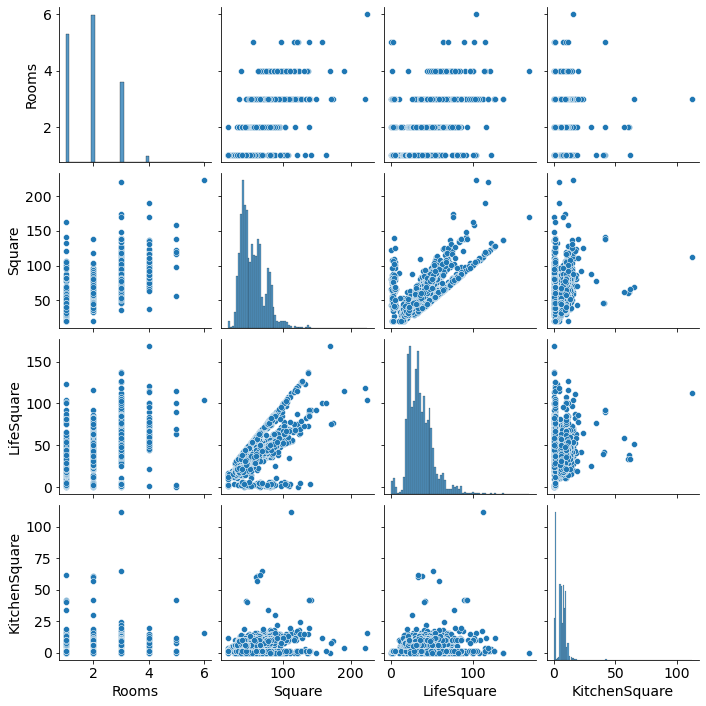

In [106]:
sns.pairplot(df_test[square_feats])

<i>Тут вот у меня мысли уже появляются по поводу аномально больших кухонь, например (график $LifeSquare=f(KitchenSquare)$), ровно, как и слишком маленькие жилые площади, но опять же, пока оставлю такой вариант, а чуть потом проверю как будет скор влиять, если такие вещи поменять

### Фичи

Дропаем здравоохранение, делаем районные фичи $DistCounts, DistAge, DistMedPrice$

In [107]:
df_test.drop(columns='Healthcare_1', inplace=True)

##### DistCounts

In [108]:
df_test['DistCounts'] = df_test.DistrictId.map(dist_dict)

In [109]:
df_test.loc[df_test['DistCounts'] < 50, 'DistCounts'] = 5

##### DistAge

In [110]:
df_test['DistAge'] = df_test.DistrictId.map(dist_age)

##### DistMedPrice

In [111]:
df_test['DistMedPrice'] = df_test.DistrictId.map(price_med_dict)

In [112]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Id              5000 non-null   int16   
 1   DistrictId      5000 non-null   int16   
 2   Rooms           5000 non-null   float32 
 3   Square          5000 non-null   float32 
 4   LifeSquare      5000 non-null   float32 
 5   KitchenSquare   5000 non-null   float32 
 6   Floor           5000 non-null   float32 
 7   HouseFloor      5000 non-null   float32 
 8   HouseYear       5000 non-null   int16   
 9   Ecology_1       5000 non-null   float32 
 10  Ecology_2       5000 non-null   category
 11  Ecology_3       5000 non-null   category
 12  Social_1        5000 non-null   int8    
 13  Social_2        5000 non-null   int16   
 14  Social_3        5000 non-null   int16   
 15  Helthcare_2     5000 non-null   int8    
 16  Shops_1         5000 non-null   int8    
 17  Shops_2       

Есть NaN значения, значит в тестовом датасете присутствуют районы, которых нет в трейновом

NaN в $DistCounts$ заполним числом 5, как это сделано для $DistCounts < 50$<br>
NaN в $DistAge$ заполним 'old', т.к. это мода из трейнового датасета (но т.к. я сделал get_dummies в трейновом, то не могу через $mode()$ получить это значение)
NaN в $DistMedPrice$ заполним медианным значением из трейнового датасета

In [113]:
df_test.loc[df_test['DistCounts'].isna(), 'DistCounts'] = 5

In [114]:
df_test.loc[df_test['DistAge'].isna(), 'DistAge'] = 'old'

In [115]:
df_test.loc[df_test['DistMedPrice'].isna(), 'DistMedPrice'] = df_train.DistMedPrice.median()

In [116]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Id              5000 non-null   int16   
 1   DistrictId      5000 non-null   int16   
 2   Rooms           5000 non-null   float32 
 3   Square          5000 non-null   float32 
 4   LifeSquare      5000 non-null   float32 
 5   KitchenSquare   5000 non-null   float32 
 6   Floor           5000 non-null   float32 
 7   HouseFloor      5000 non-null   float32 
 8   HouseYear       5000 non-null   int16   
 9   Ecology_1       5000 non-null   float32 
 10  Ecology_2       5000 non-null   category
 11  Ecology_3       5000 non-null   category
 12  Social_1        5000 non-null   int8    
 13  Social_2        5000 non-null   int16   
 14  Social_3        5000 non-null   int16   
 15  Helthcare_2     5000 non-null   int8    
 16  Shops_1         5000 non-null   int8    
 17  Shops_2       

Пропущенных значений нет. Закастим $DistAge$ к категории, чтобы get_dummies() ее увидела.

In [117]:
df_test['DistAge'] = df_test['DistAge'].astype('category')

In [118]:
df_test = pd.get_dummies(df_test)

In [119]:
df_test.set_index('Id', inplace=True)

In [120]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 725 to 12504
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DistrictId        5000 non-null   int16  
 1   Rooms             5000 non-null   float32
 2   Square            5000 non-null   float32
 3   LifeSquare        5000 non-null   float32
 4   KitchenSquare     5000 non-null   float32
 5   Floor             5000 non-null   float32
 6   HouseFloor        5000 non-null   float32
 7   HouseYear         5000 non-null   int16  
 8   Ecology_1         5000 non-null   float32
 9   Social_1          5000 non-null   int8   
 10  Social_2          5000 non-null   int16  
 11  Social_3          5000 non-null   int16  
 12  Helthcare_2       5000 non-null   int8   
 13  Shops_1           5000 non-null   int8   
 14  FloorPos          5000 non-null   float32
 15  SquarePerRoom     5000 non-null   float32
 16  KitchenSqRatio    5000 non-null   float

In [121]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   DistrictId        10000 non-null  category
 1   Rooms             10000 non-null  float32 
 2   Square            10000 non-null  float32 
 3   LifeSquare        10000 non-null  float32 
 4   KitchenSquare     10000 non-null  float32 
 5   Floor             10000 non-null  float32 
 6   HouseFloor        10000 non-null  float32 
 7   HouseYear         10000 non-null  category
 8   Ecology_1         10000 non-null  float32 
 9   Social_1          10000 non-null  int8    
 10  Social_2          10000 non-null  int16   
 11  Social_3          10000 non-null  int16   
 12  Helthcare_2       10000 non-null  int8    
 13  Shops_1           10000 non-null  int8    
 14  FloorPos          10000 non-null  float32 
 15  SquarePerRoom     10000 non-null  float32 
 16  LifeSqRatio       1

По количествам фичей все хорошо. Кастим $DistrictId,HouseYear$ к категории

In [122]:
df_test['DistrictId'] = df_test['DistrictId'].astype('category')
df_test['HouseYear'] = df_test['HouseYear'].astype('category')

In [123]:
df_test.to_csv(prep_test)

## Обучение модели

В качестве модели выбран LGBMRegressor по причине того, что в данной задаче, как я понял, не столько важна модель, сколько качество данных и фич,а также по причине того, что он использовался и в бейслайне, и Вероникой на последнем семинаре.

Использоваться будут вот такие фичи. Это почти весь набор из датасетов, но за вычетом $Ecology_2, Shops_2$, т.к. у них был самый низкий feature_importances

In [129]:
features = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Helthcare_2', 'Shops_1', 'FloorPos', 'SquarePerRoom',
       'LifeSqRatio', 'KitchenSqRatio', 'DistCounts',
       'DistAge_new', 'DistAge_old', 'DistAge_very old', 'DistMedPrice']

In [125]:
params = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 400, 500],
    'max_depth': [3, 5, 7, 8, 10, 15]
}

In [126]:
model = LGBMRegressor(num_leaves=31, 
                      random_state=42
                     )

In [127]:
grid_search = GridSearchCV(model, 
                           params,
                           scoring='r2',
                           cv=KFold(n_splits=5, random_state=21, shuffle=True),
                           n_jobs=-1
                          )

In [130]:
grid_search.fit(df_train[features], target)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 8, 10, 15],
                         'n_estimators': [50, 100, 150, 200, 250, 300, 400,
                                          500]},
             scoring='r2')

Странный error_message, ибо там явно указано num_leaves, а max_depth берется из grid_search. И вместо привычных X_train у меня df_train, но понятно, что в df_train нет целевого столбца

In [131]:
grid_search.best_params_

{'max_depth': 15, 'n_estimators': 150}

In [132]:
grid_search.best_score_

0.7492711815428834

Вот тут еще странно: на public leaderboard'e скор выше, что наводит на мысли, что на private leaderboard'e скор может сильно упасть

In [133]:
final_model = LGBMRegressor(num_leaves=31, max_depth=15, n_estimators=150, random_state=42)

In [134]:
final_model.fit(df_train[features], target)

LGBMRegressor(max_depth=15, n_estimators=150, random_state=42)

Построим график feature_importances

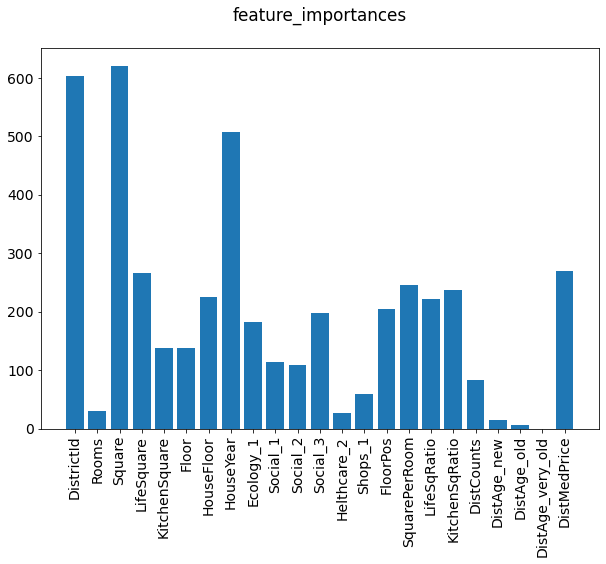

In [147]:
plt.figure(figsize=(10, 7))
plt.bar(final_model.feature_name_, final_model.feature_importances_)
plt.xticks(rotation=90)
plt.title('feature_importances\n')
plt.show()

In [136]:
y_pred = final_model.predict(df_train[features])

In [138]:
r2(target, y_pred)

0.9223857371385165

O_o однако, переобучение, как я понимаю

In [139]:
y_kaggle = final_model.predict(df_test[features])

In [141]:
y_kaggle_df = pd.DataFrame(columns=['Id', 'Price'])
y_kaggle_df['Price'] = y_kaggle
y_kaggle_df['Id'] = df_test.index

In [144]:
y_kaggle_df

,Id,Price
0,725,158730.296813
1,15856,217533.040986
2,5480,301965.588972
3,15664,309154.890112
4,14275,142354.027315
...,...,...
4995,8180,245207.338210
4996,4695,134581.172136
4997,5783,297848.201731
4998,4780,189346.967548


In [145]:
y_kaggle_df.to_csv('predictions.csv', index=False)

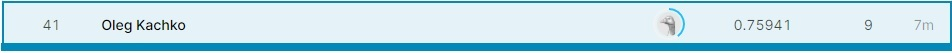

In [149]:
Image('datasets/kaggle.jpg')